In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sounddevice as sd
import soundfile as sf
import librosa
import audiolazy
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset as TorchDataset
from torch.utils.data import DataLoader
from torchsummary import summary
from tqdm import tqdm
import torch
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

import analysis

In [2]:
# For constant
categories = {0: "tram",
             1: "car"}

In [3]:
DATA_DIR = "./data"

# Load train data
class0_train_dir = os.path.join(DATA_DIR, "normalized_train_tram") 
class1_train_dir = os.path.join(DATA_DIR, "normalized_train_car") 
 
class0_train_files = [os.path.join(class0_train_dir, file) for file in os.listdir(class0_train_dir)]
class1_train_files = [os.path.join(class1_train_dir, file) for file in os.listdir(class1_train_dir)]

# Load validation data
class0_valid_dir = os.path.join(DATA_DIR, "normalized_valid_tram") 
class1_valid_dir = os.path.join(DATA_DIR, "normalized_valid_car") 
 
class0_valid_files = [os.path.join(class0_valid_dir, file) for file in os.listdir(class0_valid_dir)]
class1_valid_files = [os.path.join(class1_valid_dir, file) for file in os.listdir(class1_valid_dir)]

# Load test data
class0_test_dir = os.path.join(DATA_DIR, "normalized_test_tram") 
class1_test_dir = os.path.join(DATA_DIR, "normalized_test_car") 
 
class0_test_files = [os.path.join(class0_test_dir, file) for file in os.listdir(class0_test_dir)]
class1_test_files = [os.path.join(class1_test_dir, file) for file in os.listdir(class1_test_dir)]

Class tram
./data/normalized_train_tram/train_tram_005.wav


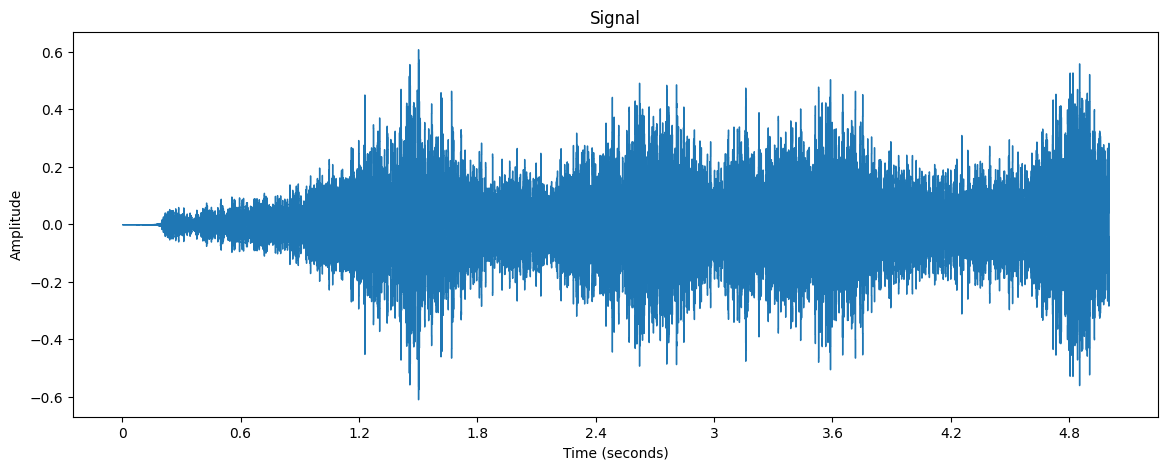

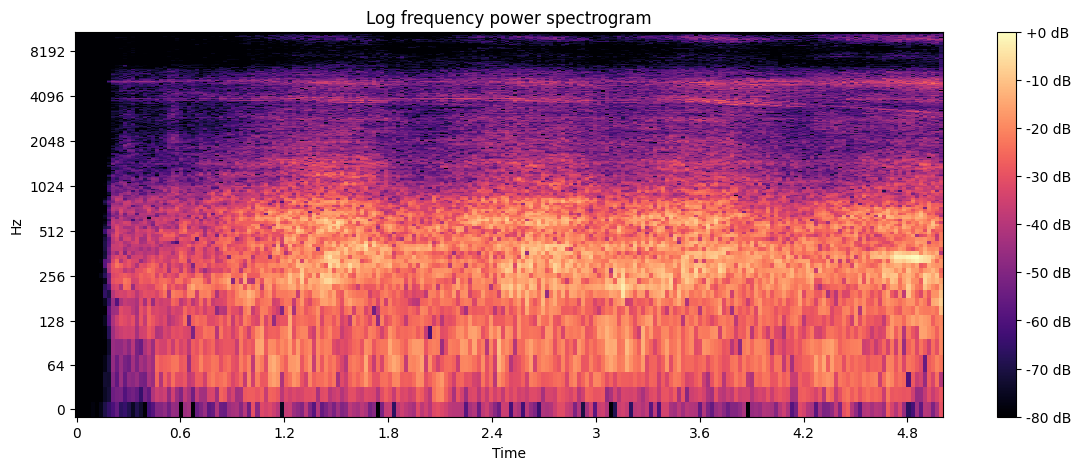

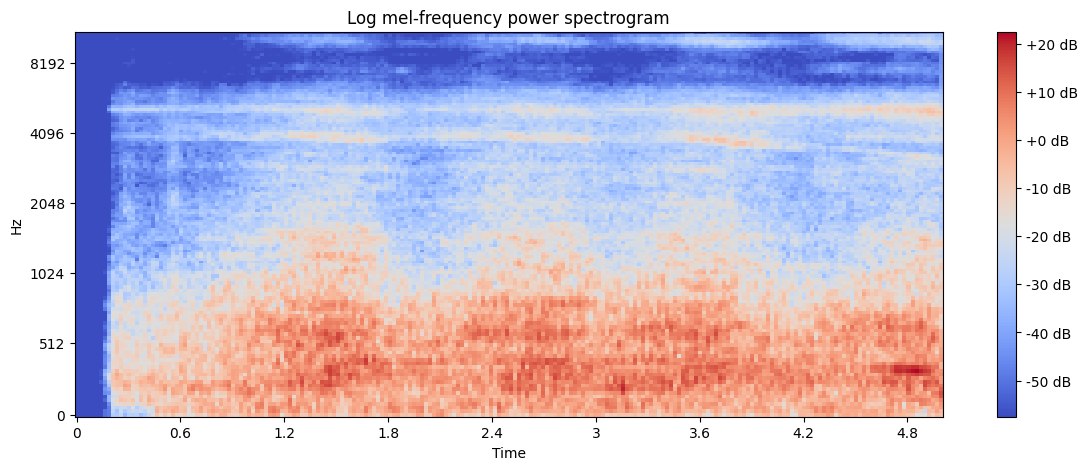

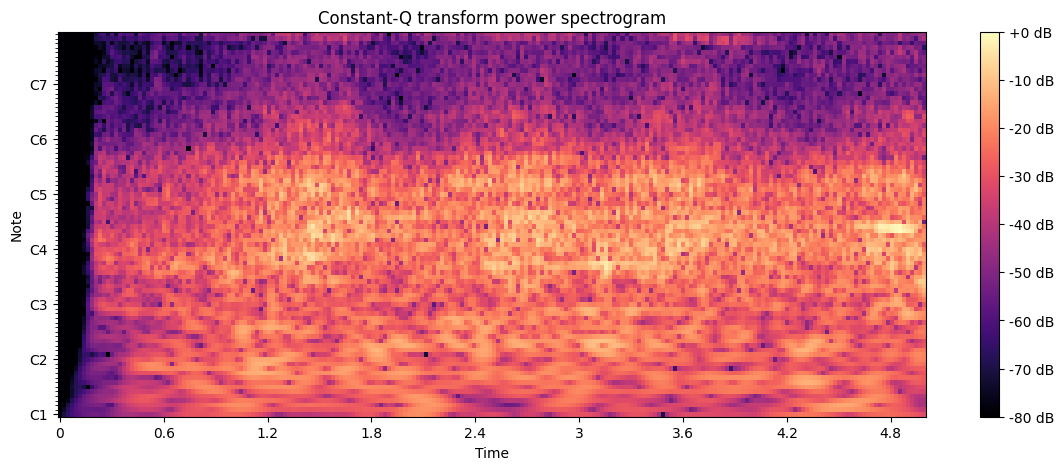

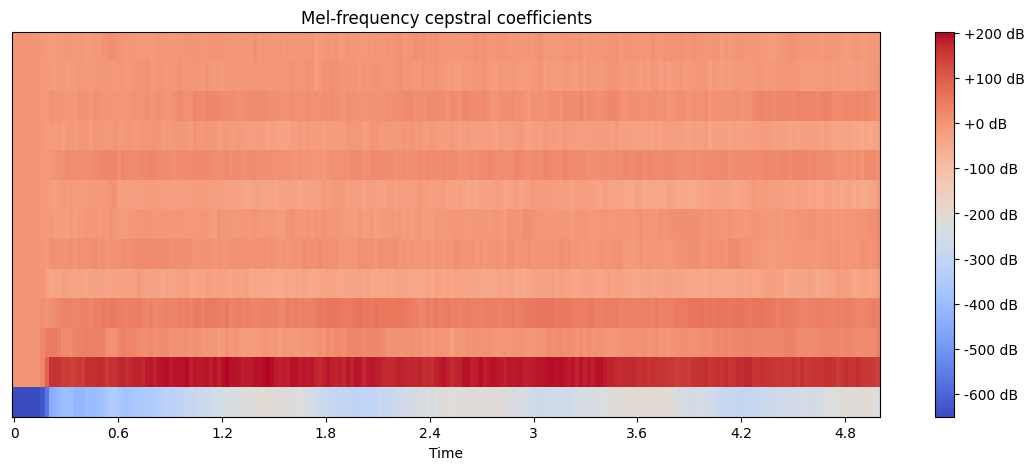

In [27]:
# Feature analysis
# Class 0
sample_file = class0_train_files[4]

print(f"Class {categories[0]}")
print(sample_file)

features = analysis.feature_extraction(sample_file)

Class car
./data/normalized_train_car/train_car_043.wav


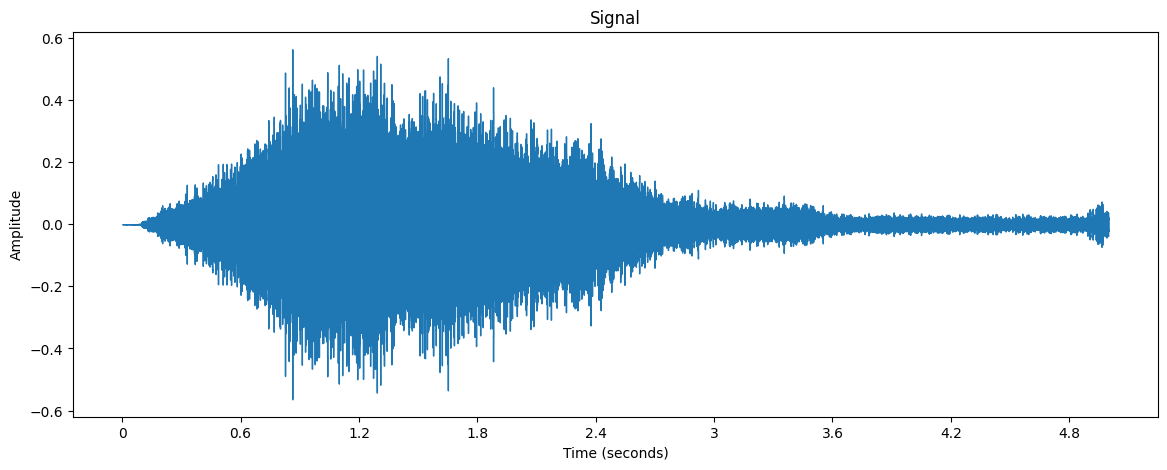

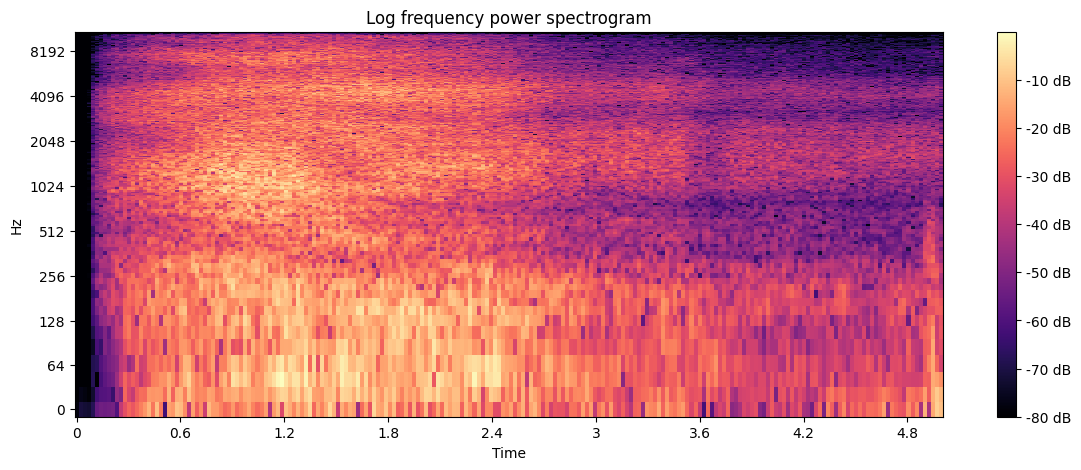

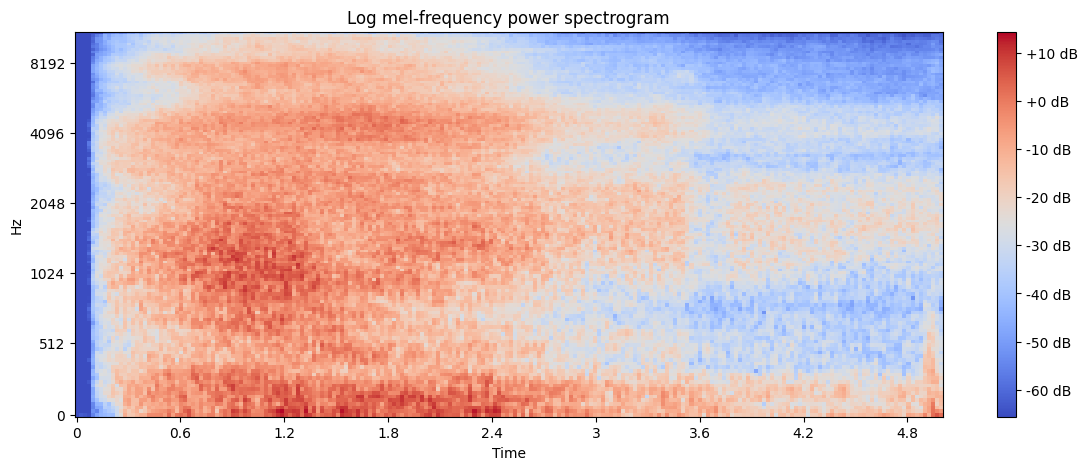

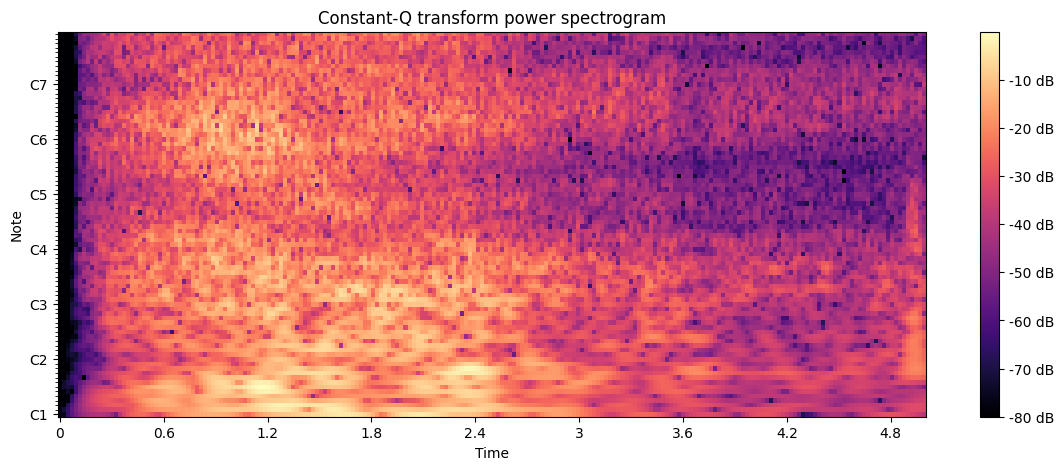

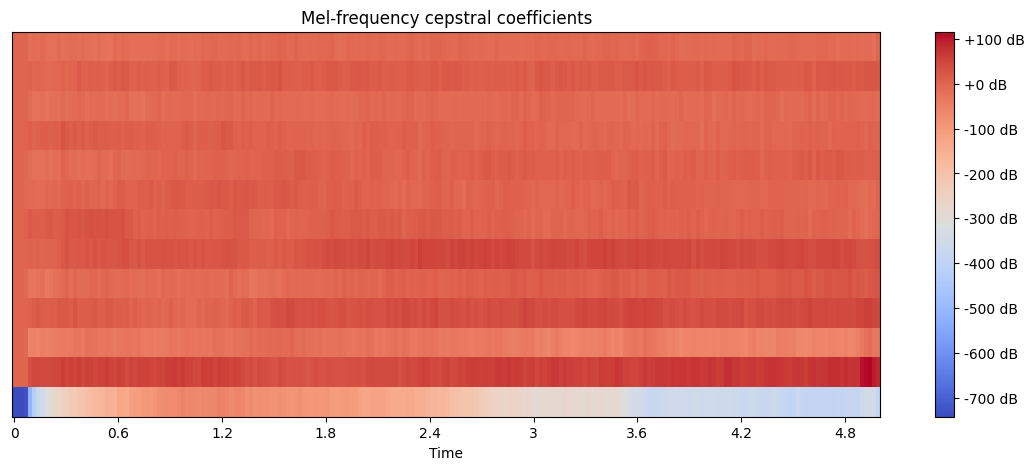

In [26]:
# Class 1
sample_file = class1_train_files[2]

print(f"Class {categories[1]}")
print(sample_file)

features = analysis.feature_extraction(sample_file)

In [6]:
# Extract features
class0_train_features = [analysis.feature_extraction(file, is_plot = False) for file in class0_train_files]
class0_valid_features = [analysis.feature_extraction(file, is_plot = False) for file in class0_valid_files]
class0_test_features = [analysis.feature_extraction(file, is_plot = False) for file in class0_test_files]

class1_train_features = [analysis.feature_extraction(file, is_plot = False) for file in class1_train_files]
class1_valid_features = [analysis.feature_extraction(file, is_plot = False) for file in class1_valid_files]
class1_test_features = [analysis.feature_extraction(file, is_plot = False) for file in class1_test_files]

In [7]:
# List of values for energy, rms, zcr
class0_energy = [feature["energy"] 
                 for feature in class0_train_features + class0_valid_features + class0_test_features]
class0_rms = [feature["rms"]
              for feature in class0_train_features + class0_valid_features + class0_test_features]
class0_zcr = [feature["zcr"]
              for feature in class0_train_features + class0_valid_features + class0_test_features]

class1_energy = [feature["energy"] 
                 for feature in class1_train_features + class1_valid_features + class1_test_features]
class1_rms = [feature["rms"]
              for feature in class1_train_features + class1_valid_features + class1_test_features]
class1_zcr = [feature["zcr"]
              for feature in class1_train_features + class1_valid_features + class1_test_features]

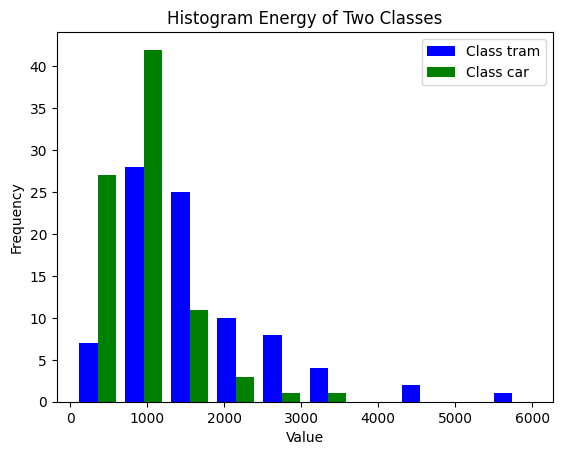

In [8]:
# Creating the histogram for energy
plt.hist([class0_energy, class1_energy], color=['blue', 'green'], 
         label=[f'Class {categories[0]}', f'Class {categories[1]}'])

# Adding title and labels
plt.title('Histogram Energy of Two Classes')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

# Display the histogram
plt.show()

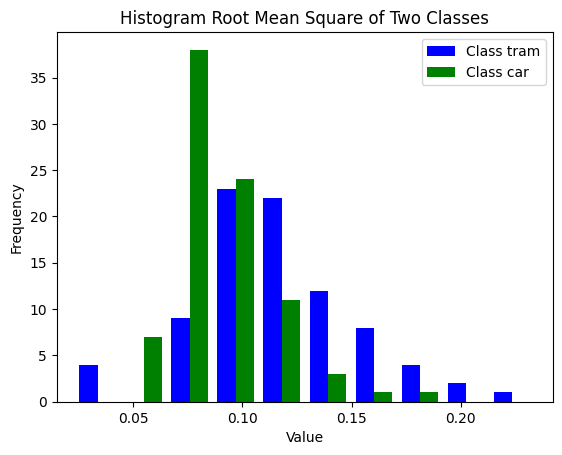

In [9]:
# Creating the histogram for RMS
plt.hist([class0_rms, class1_rms], color=['blue', 'green'], 
         label=[f'Class {categories[0]}', f'Class {categories[1]}'])

# Adding title and labels
plt.title('Histogram Root Mean Square of Two Classes')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

# Display the histogram
plt.show()


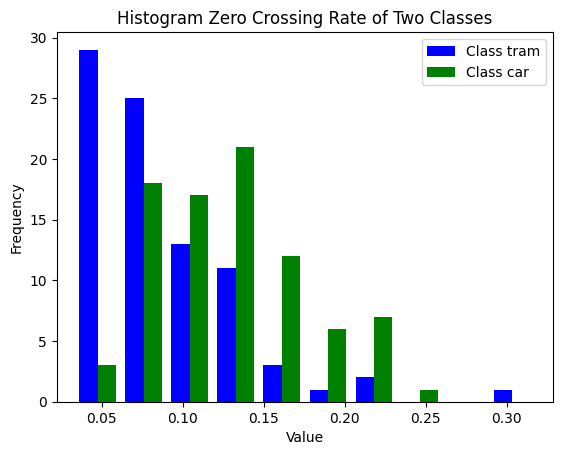

In [10]:
# Creating the histogram for zero cross rate
plt.hist([class0_zcr, class1_zcr], color=['blue', 'green'], 
         label=[f'Class {categories[0]}', f'Class {categories[1]}'])

# Adding title and labels
plt.title('Histogram Zero Crossing Rate of Two Classes')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

# Display the histogram
plt.show()


# Binary classification

## Dataset

In [11]:
# Define Dataset class
class Dataset(TorchDataset):
    def __init__(self, *args):
        super().__init__()
        self.x = np.array([item[0] for item in args[0]])
        self.y = np.array([item[1] for item in args[0]])

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        return x, y


In [12]:
# Concatenate features of all class spectrogram, mel_spectrogram, cqt, mfcc

# Train
class0_train_x = [np.concatenate([feature['log_spectrogram'], 
                            feature['logmel_spectrogram'],
                            feature['cqt_spectrogram'],
                            feature['mfcc']], axis = 0) for feature in class0_train_features]
class0_train_y = [0 for i in range(len(class0_train_features))]


class1_train_x = [np.concatenate([feature['log_spectrogram'], 
                            feature['logmel_spectrogram'],
                            feature['cqt_spectrogram'],
                            feature['mfcc']], axis = 0) for feature in class1_train_features]
class1_train_y = [1 for i in range(len(class1_train_features))]


# Train split
class0_train = list(zip(class0_train_x, class0_train_y))
class1_train = list(zip(class1_train_x, class1_train_y))
train = class0_train + class1_train

# Validation
class0_valid_x = [np.concatenate([feature['log_spectrogram'], 
                            feature['logmel_spectrogram'],
                            feature['cqt_spectrogram'],
                            feature['mfcc']], axis = 0) for feature in class0_valid_features]
class0_valid_y = [0 for i in range(len(class0_valid_features))]


class1_valid_x = [np.concatenate([feature['log_spectrogram'], 
                            feature['logmel_spectrogram'],
                            feature['cqt_spectrogram'],
                            feature['mfcc']], axis = 0) for feature in class1_train_features]
class1_valid_y = [1 for i in range(len(class1_valid_features))]


# Validation split
class0_valid = list(zip(class0_valid_x, class0_valid_y))
class1_valid = list(zip(class1_valid_x, class1_valid_y))
valid = class0_valid + class1_valid


# Test
class0_test_x = [np.concatenate([feature['log_spectrogram'], 
                            feature['logmel_spectrogram'],
                            feature['cqt_spectrogram'],
                            feature['mfcc']], axis = 0) for feature in class0_test_features]
class0_test_y = [0 for i in range(len(class0_test_features))]


class1_test_x = [np.concatenate([feature['log_spectrogram'], 
                            feature['logmel_spectrogram'],
                            feature['cqt_spectrogram'],
                            feature['mfcc']], axis = 0) for feature in class1_test_features]
class1_test_y = [1 for i in range(len(class1_test_features))]


# Test split
class0_test = list(zip(class0_test_x, class0_test_y))
class1_test = list(zip(class1_test_x, class1_test_y))
test = class0_test + class1_test

In [13]:
# Construct dataset
train_dataset = Dataset(train)
valid_dataset = Dataset(valid)
test_dataset = Dataset(test)

# Construct dataloader
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True)

# Define model

In [14]:
class Simple1DNet(nn.Module):
    def __init__(self):
        super(Simple1DNet, self).__init__()
        # Define your layers here
        self.conv1 = nn.Conv1d(in_channels=738, out_channels=64, kernel_size=3, stride=2)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, stride=2)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=1)
        self.fc = nn.Linear(32*27, 1)  # Adjust the size according to your pooling and conv layers
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Define the forward pass
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x


In [15]:
# Define model
model = Simple1DNet()
#x = torch.rand((1, 738, 216))
#model(x)
# Model summary
model_summary = summary(model, input_size=(738, 216), device="cpu")
model_summary

# Number of params
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 64, 107]         141,760
              ReLU-2              [-1, 64, 107]               0
            Conv1d-3               [-1, 32, 53]           6,176
              ReLU-4               [-1, 32, 53]               0
         MaxPool1d-5               [-1, 32, 27]               0
            Linear-6                    [-1, 1]             865
           Sigmoid-7                    [-1, 1]               0
Total params: 148,801
Trainable params: 148,801
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.61
Forward/backward pass size (MB): 0.14
Params size (MB): 0.57
Estimated Total Size (MB): 1.31
----------------------------------------------------------------
148801


## Training

In [16]:
# Training hyperparameters
num_epochs = 100
lr = 0.0001
# Training loss and optimizer
loss_fun = nn.BCELoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

model.train()
# Training loop
for epoch in tqdm(range(num_epochs)):
    for i, (inputs, labels) in enumerate(train_loader):  # Assuming you have a DataLoader
        # Forward pass
        outputs = model(inputs)
        # Remove dim with 1
        outputs = torch.squeeze(outputs)
       
        labels = labels.float()
        loss = loss_fun(outputs, labels)
        #print(outputs)
        print(loss)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


  0%|                                                   | 0/150 [00:00<?, ?it/s]

tensor(3.4205, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(2.6696, grad_fn=<BinaryCrossEntropyBackward0>)


  1%|▌                                          | 2/150 [00:00<00:56,  2.64it/s]

tensor(2.5064, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.9207, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.1272, grad_fn=<BinaryCrossEntropyBackward0>)


  2%|▊                                          | 3/150 [00:01<00:43,  3.35it/s]

tensor(1.2746, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.3317, grad_fn=<BinaryCrossEntropyBackward0>)


  3%|█▏                                         | 4/150 [00:01<00:40,  3.64it/s]

tensor(0.9576, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6359, grad_fn=<BinaryCrossEntropyBackward0>)


  3%|█▍                                         | 5/150 [00:01<00:36,  3.93it/s]

tensor(0.7753, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.1382, grad_fn=<BinaryCrossEntropyBackward0>)


  4%|█▋                                         | 6/150 [00:01<00:34,  4.17it/s]

tensor(0.6369, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4618, grad_fn=<BinaryCrossEntropyBackward0>)


  5%|██                                         | 7/150 [00:01<00:33,  4.30it/s]

tensor(0.7227, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.7329, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6000, grad_fn=<BinaryCrossEntropyBackward0>)


  6%|██▌                                        | 9/150 [00:02<00:31,  4.53it/s]

tensor(0.4417, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4441, grad_fn=<BinaryCrossEntropyBackward0>)


  7%|██▊                                       | 10/150 [00:02<00:30,  4.60it/s]

tensor(0.4347, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6470, grad_fn=<BinaryCrossEntropyBackward0>)


  7%|███                                       | 11/150 [00:02<00:30,  4.61it/s]

tensor(0.3590, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3353, grad_fn=<BinaryCrossEntropyBackward0>)


  8%|███▎                                      | 12/150 [00:02<00:29,  4.62it/s]

tensor(0.4098, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5783, grad_fn=<BinaryCrossEntropyBackward0>)


  9%|███▋                                      | 13/150 [00:03<00:29,  4.69it/s]

tensor(0.3647, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2753, grad_fn=<BinaryCrossEntropyBackward0>)


  9%|███▉                                      | 14/150 [00:03<00:29,  4.66it/s]

tensor(0.3567, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3254, grad_fn=<BinaryCrossEntropyBackward0>)


 10%|████▏                                     | 15/150 [00:03<00:28,  4.74it/s]

tensor(0.3031, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2814, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2648, grad_fn=<BinaryCrossEntropyBackward0>)


 11%|████▍                                     | 16/150 [00:03<00:28,  4.75it/s]

tensor(0.2313, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3056, grad_fn=<BinaryCrossEntropyBackward0>)


 11%|████▊                                     | 17/150 [00:04<00:27,  4.81it/s]

tensor(0.2055, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2229, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1923, grad_fn=<BinaryCrossEntropyBackward0>)


 13%|█████▎                                    | 19/150 [00:04<00:26,  4.90it/s]

tensor(0.2086, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2516, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2032, grad_fn=<BinaryCrossEntropyBackward0>)


 13%|█████▌                                    | 20/150 [00:04<00:26,  4.92it/s]

tensor(0.1848, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1851, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2008, grad_fn=<BinaryCrossEntropyBackward0>)


 15%|██████▏                                   | 22/150 [00:05<00:28,  4.56it/s]

tensor(0.1787, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1770, grad_fn=<BinaryCrossEntropyBackward0>)


 15%|██████▍                                   | 23/150 [00:05<00:29,  4.37it/s]

tensor(0.1732, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1412, grad_fn=<BinaryCrossEntropyBackward0>)


 16%|██████▋                                   | 24/150 [00:05<00:28,  4.41it/s]

tensor(0.1547, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1532, grad_fn=<BinaryCrossEntropyBackward0>)


 17%|███████                                   | 25/150 [00:05<00:27,  4.47it/s]

tensor(0.1478, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1323, grad_fn=<BinaryCrossEntropyBackward0>)


 17%|███████▎                                  | 26/150 [00:05<00:27,  4.52it/s]

tensor(0.1598, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0992, grad_fn=<BinaryCrossEntropyBackward0>)


 18%|███████▌                                  | 27/150 [00:06<00:26,  4.63it/s]

tensor(0.1417, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1116, grad_fn=<BinaryCrossEntropyBackward0>)


 19%|███████▊                                  | 28/150 [00:06<00:26,  4.62it/s]

tensor(0.1162, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1480, grad_fn=<BinaryCrossEntropyBackward0>)


 19%|████████                                  | 29/150 [00:06<00:26,  4.63it/s]

tensor(0.1291, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0978, grad_fn=<BinaryCrossEntropyBackward0>)


 20%|████████▍                                 | 30/150 [00:06<00:25,  4.75it/s]

tensor(0.1265, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0826, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1093, grad_fn=<BinaryCrossEntropyBackward0>)


 21%|████████▋                                 | 31/150 [00:07<00:24,  4.76it/s]

tensor(0.1068, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1095, grad_fn=<BinaryCrossEntropyBackward0>)


 21%|████████▉                                 | 32/150 [00:07<00:24,  4.79it/s]

tensor(0.0933, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0966, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1025, grad_fn=<BinaryCrossEntropyBackward0>)


 23%|█████████▌                                | 34/150 [00:07<00:24,  4.82it/s]

tensor(0.0967, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1004, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0949, grad_fn=<BinaryCrossEntropyBackward0>)


 23%|█████████▊                                | 35/150 [00:07<00:23,  4.82it/s]

tensor(0.0883, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0844, grad_fn=<BinaryCrossEntropyBackward0>)


 24%|██████████                                | 36/150 [00:08<00:23,  4.84it/s]

tensor(0.0940, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0829, grad_fn=<BinaryCrossEntropyBackward0>)


 25%|██████████▎                               | 37/150 [00:08<00:23,  4.80it/s]

tensor(0.0973, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0916, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0620, grad_fn=<BinaryCrossEntropyBackward0>)


 26%|██████████▉                               | 39/150 [00:08<00:22,  4.88it/s]

tensor(0.0797, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0739, grad_fn=<BinaryCrossEntropyBackward0>)


 27%|███████████▏                              | 40/150 [00:08<00:22,  4.83it/s]

tensor(0.0748, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0799, grad_fn=<BinaryCrossEntropyBackward0>)


 27%|███████████▍                              | 41/150 [00:09<00:22,  4.84it/s]

tensor(0.0797, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0437, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0732, grad_fn=<BinaryCrossEntropyBackward0>)


 28%|███████████▊                              | 42/150 [00:09<00:22,  4.88it/s]

tensor(0.0649, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0694, grad_fn=<BinaryCrossEntropyBackward0>)


 29%|████████████                              | 43/150 [00:09<00:22,  4.82it/s]

tensor(0.0578, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0667, grad_fn=<BinaryCrossEntropyBackward0>)


 29%|████████████▎                             | 44/150 [00:09<00:21,  4.85it/s]

tensor(0.0638, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0573, grad_fn=<BinaryCrossEntropyBackward0>)


 30%|████████████▌                             | 45/150 [00:09<00:21,  4.77it/s]

tensor(0.0631, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0633, grad_fn=<BinaryCrossEntropyBackward0>)


 31%|████████████▉                             | 46/150 [00:10<00:21,  4.82it/s]

tensor(0.0771, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0560, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0643, grad_fn=<BinaryCrossEntropyBackward0>)


 32%|█████████████▍                            | 48/150 [00:10<00:20,  4.89it/s]

tensor(0.0606, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0562, grad_fn=<BinaryCrossEntropyBackward0>)


 33%|█████████████▋                            | 49/150 [00:10<00:20,  4.90it/s]

tensor(0.0669, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0560, grad_fn=<BinaryCrossEntropyBackward0>)


 33%|██████████████                            | 50/150 [00:10<00:20,  4.87it/s]

tensor(0.0504, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0453, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0674, grad_fn=<BinaryCrossEntropyBackward0>)


 34%|██████████████▎                           | 51/150 [00:11<00:19,  4.95it/s]

tensor(0.0363, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0447, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0583, grad_fn=<BinaryCrossEntropyBackward0>)


 35%|██████████████▊                           | 53/150 [00:11<00:19,  5.00it/s]

tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0337, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0542, grad_fn=<BinaryCrossEntropyBackward0>)


 36%|███████████████                           | 54/150 [00:11<00:19,  4.98it/s]

tensor(0.0358, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0391, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0454, grad_fn=<BinaryCrossEntropyBackward0>)


 37%|███████████████▋                          | 56/150 [00:12<00:18,  4.98it/s]

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0334, grad_fn=<BinaryCrossEntropyBackward0>)


 38%|███████████████▉                          | 57/150 [00:12<00:18,  4.96it/s]

tensor(0.0473, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0315, grad_fn=<BinaryCrossEntropyBackward0>)


 39%|████████████████▏                         | 58/150 [00:12<00:18,  4.90it/s]

tensor(0.0430, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0297, grad_fn=<BinaryCrossEntropyBackward0>)


 39%|████████████████▌                         | 59/150 [00:12<00:18,  4.94it/s]

tensor(0.0477, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0303, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0292, grad_fn=<BinaryCrossEntropyBackward0>)


 40%|████████████████▊                         | 60/150 [00:12<00:18,  4.94it/s]

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0408, grad_fn=<BinaryCrossEntropyBackward0>)


 41%|█████████████████                         | 61/150 [00:13<00:18,  4.93it/s]

tensor(0.0303, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0421, grad_fn=<BinaryCrossEntropyBackward0>)


 41%|█████████████████▎                        | 62/150 [00:13<00:17,  4.90it/s]

tensor(0.0176, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0356, grad_fn=<BinaryCrossEntropyBackward0>)


 42%|█████████████████▋                        | 63/150 [00:13<00:18,  4.71it/s]

tensor(0.0290, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0407, grad_fn=<BinaryCrossEntropyBackward0>)


 43%|█████████████████▉                        | 64/150 [00:13<00:18,  4.77it/s]

tensor(0.0158, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0313, grad_fn=<BinaryCrossEntropyBackward0>)


 43%|██████████████████▏                       | 65/150 [00:14<00:18,  4.68it/s]

tensor(0.0297, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0272, grad_fn=<BinaryCrossEntropyBackward0>)


 44%|██████████████████▍                       | 66/150 [00:14<00:18,  4.64it/s]

tensor(0.0434, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0329, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0201, grad_fn=<BinaryCrossEntropyBackward0>)


 45%|███████████████████                       | 68/150 [00:14<00:16,  4.87it/s]

tensor(0.0341, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0304, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0330, grad_fn=<BinaryCrossEntropyBackward0>)


 46%|███████████████████▎                      | 69/150 [00:14<00:16,  4.93it/s]

tensor(0.0204, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0205, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0486, grad_fn=<BinaryCrossEntropyBackward0>)


 47%|███████████████████▉                      | 71/150 [00:15<00:15,  5.03it/s]

tensor(0.0239, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0416, grad_fn=<BinaryCrossEntropyBackward0>)


 48%|████████████████████▏                     | 72/150 [00:15<00:16,  4.86it/s]

tensor(0.0247, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0286, grad_fn=<BinaryCrossEntropyBackward0>)


 49%|████████████████████▍                     | 73/150 [00:15<00:16,  4.79it/s]

tensor(0.0243, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0289, grad_fn=<BinaryCrossEntropyBackward0>)


 49%|████████████████████▋                     | 74/150 [00:15<00:16,  4.71it/s]

tensor(0.0202, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0436, grad_fn=<BinaryCrossEntropyBackward0>)


 50%|█████████████████████                     | 75/150 [00:16<00:15,  4.74it/s]

tensor(0.0264, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0189, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0208, grad_fn=<BinaryCrossEntropyBackward0>)


 51%|█████████████████████▎                    | 76/150 [00:16<00:15,  4.76it/s]

tensor(0.0427, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0244, grad_fn=<BinaryCrossEntropyBackward0>)


 51%|█████████████████████▌                    | 77/150 [00:16<00:15,  4.72it/s]

tensor(0.0241, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0175, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0423, grad_fn=<BinaryCrossEntropyBackward0>)


 53%|██████████████████████                    | 79/150 [00:16<00:15,  4.61it/s]

tensor(0.0223, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0188, grad_fn=<BinaryCrossEntropyBackward0>)


 53%|██████████████████████▍                   | 80/150 [00:17<00:14,  4.70it/s]

tensor(0.0299, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0142, grad_fn=<BinaryCrossEntropyBackward0>)


 54%|██████████████████████▋                   | 81/150 [00:17<00:15,  4.56it/s]

tensor(0.0203, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0228, grad_fn=<BinaryCrossEntropyBackward0>)


 55%|██████████████████████▉                   | 82/150 [00:17<00:15,  4.35it/s]

tensor(0.0186, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0360, grad_fn=<BinaryCrossEntropyBackward0>)


 55%|███████████████████████▏                  | 83/150 [00:17<00:15,  4.42it/s]

tensor(0.0243, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0140, grad_fn=<BinaryCrossEntropyBackward0>)


 56%|███████████████████████▌                  | 84/150 [00:18<00:14,  4.52it/s]

tensor(0.0240, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0073, grad_fn=<BinaryCrossEntropyBackward0>)


 57%|███████████████████████▊                  | 85/150 [00:18<00:13,  4.66it/s]

tensor(0.0216, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0150, grad_fn=<BinaryCrossEntropyBackward0>)


 57%|████████████████████████                  | 86/150 [00:18<00:13,  4.65it/s]

tensor(0.0205, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0121, grad_fn=<BinaryCrossEntropyBackward0>)


 58%|████████████████████████▎                 | 87/150 [00:18<00:13,  4.77it/s]

tensor(0.0167, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0194, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0198, grad_fn=<BinaryCrossEntropyBackward0>)


 59%|████████████████████████▋                 | 88/150 [00:18<00:12,  4.86it/s]

tensor(0.0094, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0179, grad_fn=<BinaryCrossEntropyBackward0>)


 59%|████████████████████████▉                 | 89/150 [00:19<00:12,  4.80it/s]

tensor(0.0124, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0188, grad_fn=<BinaryCrossEntropyBackward0>)


 60%|█████████████████████████▏                | 90/150 [00:19<00:12,  4.77it/s]

tensor(0.0090, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0199, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0070, grad_fn=<BinaryCrossEntropyBackward0>)


 61%|█████████████████████████▊                | 92/150 [00:19<00:11,  4.85it/s]

tensor(0.0131, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0212, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0186, grad_fn=<BinaryCrossEntropyBackward0>)


 62%|██████████████████████████                | 93/150 [00:19<00:11,  4.92it/s]

tensor(0.0067, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0140, grad_fn=<BinaryCrossEntropyBackward0>)


 63%|██████████████████████████▎               | 94/150 [00:20<00:11,  4.94it/s]

tensor(0.0189, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0150, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0118, grad_fn=<BinaryCrossEntropyBackward0>)


 64%|██████████████████████████▉               | 96/150 [00:20<00:10,  4.95it/s]

tensor(0.0121, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0259, grad_fn=<BinaryCrossEntropyBackward0>)


 65%|███████████████████████████▏              | 97/150 [00:20<00:10,  4.99it/s]

tensor(0.0154, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0126, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0130, grad_fn=<BinaryCrossEntropyBackward0>)


 65%|███████████████████████████▍              | 98/150 [00:20<00:10,  4.93it/s]

tensor(0.0209, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0157, grad_fn=<BinaryCrossEntropyBackward0>)


 66%|███████████████████████████▋              | 99/150 [00:21<00:10,  4.88it/s]

tensor(0.0071, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0118, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0244, grad_fn=<BinaryCrossEntropyBackward0>)


 67%|███████████████████████████▌             | 101/150 [00:21<00:09,  4.94it/s]

tensor(0.0146, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0110, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0137, grad_fn=<BinaryCrossEntropyBackward0>)


 68%|███████████████████████████▉             | 102/150 [00:21<00:09,  4.99it/s]

tensor(0.0130, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0116, grad_fn=<BinaryCrossEntropyBackward0>)


 69%|████████████████████████████▏            | 103/150 [00:21<00:09,  4.96it/s]

tensor(0.0168, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0137, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0073, grad_fn=<BinaryCrossEntropyBackward0>)


 70%|████████████████████████████▋            | 105/150 [00:22<00:08,  5.05it/s]

tensor(0.0124, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0246, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0113, grad_fn=<BinaryCrossEntropyBackward0>)


 71%|████████████████████████████▉            | 106/150 [00:22<00:08,  5.06it/s]

tensor(0.0163, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0104, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0199, grad_fn=<BinaryCrossEntropyBackward0>)


 72%|█████████████████████████████▌           | 108/150 [00:22<00:08,  5.07it/s]

tensor(0.0132, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0063, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0139, grad_fn=<BinaryCrossEntropyBackward0>)


 73%|█████████████████████████████▊           | 109/150 [00:23<00:08,  5.09it/s]

tensor(0.0055, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0162, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0067, grad_fn=<BinaryCrossEntropyBackward0>)


 74%|██████████████████████████████▎          | 111/150 [00:23<00:07,  4.92it/s]

tensor(0.0132, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0063, grad_fn=<BinaryCrossEntropyBackward0>)


 75%|██████████████████████████████▌          | 112/150 [00:23<00:07,  4.78it/s]

tensor(0.0122, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0049, grad_fn=<BinaryCrossEntropyBackward0>)


 75%|██████████████████████████████▉          | 113/150 [00:23<00:07,  4.77it/s]

tensor(0.0112, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0081, grad_fn=<BinaryCrossEntropyBackward0>)


 76%|███████████████████████████████▏         | 114/150 [00:24<00:07,  4.71it/s]

tensor(0.0068, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0176, grad_fn=<BinaryCrossEntropyBackward0>)


 77%|███████████████████████████████▍         | 115/150 [00:24<00:07,  4.71it/s]

tensor(0.0101, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0085, grad_fn=<BinaryCrossEntropyBackward0>)


 77%|███████████████████████████████▋         | 116/150 [00:24<00:07,  4.72it/s]

tensor(0.0100, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0078, grad_fn=<BinaryCrossEntropyBackward0>)


 78%|███████████████████████████████▉         | 117/150 [00:24<00:07,  4.64it/s]

tensor(0.0094, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0089, grad_fn=<BinaryCrossEntropyBackward0>)


 79%|████████████████████████████████▎        | 118/150 [00:24<00:06,  4.76it/s]

tensor(0.0060, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0172, grad_fn=<BinaryCrossEntropyBackward0>)


 79%|████████████████████████████████▌        | 119/150 [00:25<00:06,  4.69it/s]

tensor(0.0083, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0103, grad_fn=<BinaryCrossEntropyBackward0>)


 80%|████████████████████████████████▊        | 120/150 [00:25<00:06,  4.58it/s]

tensor(0.0092, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0071, grad_fn=<BinaryCrossEntropyBackward0>)


 81%|█████████████████████████████████        | 121/150 [00:25<00:06,  4.51it/s]

tensor(0.0082, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0098, grad_fn=<BinaryCrossEntropyBackward0>)


 81%|█████████████████████████████████▎       | 122/150 [00:25<00:06,  4.64it/s]

tensor(0.0099, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0044, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0098, grad_fn=<BinaryCrossEntropyBackward0>)


 82%|█████████████████████████████████▌       | 123/150 [00:26<00:05,  4.62it/s]

tensor(0.0056, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0096, grad_fn=<BinaryCrossEntropyBackward0>)


 83%|█████████████████████████████████▉       | 124/150 [00:26<00:05,  4.52it/s]

tensor(0.0050, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0070, grad_fn=<BinaryCrossEntropyBackward0>)


 83%|██████████████████████████████████▏      | 125/150 [00:26<00:05,  4.59it/s]

tensor(0.0115, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0070, grad_fn=<BinaryCrossEntropyBackward0>)


 84%|██████████████████████████████████▍      | 126/150 [00:26<00:05,  4.67it/s]

tensor(0.0095, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0072, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0095, grad_fn=<BinaryCrossEntropyBackward0>)


 85%|██████████████████████████████████▉      | 128/150 [00:27<00:04,  4.83it/s]

tensor(0.0089, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0069, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0080, grad_fn=<BinaryCrossEntropyBackward0>)


 86%|███████████████████████████████████▎     | 129/150 [00:27<00:04,  4.86it/s]

tensor(0.0067, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0048, grad_fn=<BinaryCrossEntropyBackward0>)


 87%|███████████████████████████████████▌     | 130/150 [00:27<00:04,  4.85it/s]

tensor(0.0153, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0054, grad_fn=<BinaryCrossEntropyBackward0>)


 87%|███████████████████████████████████▊     | 131/150 [00:27<00:03,  4.87it/s]

tensor(0.0121, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0081, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0042, grad_fn=<BinaryCrossEntropyBackward0>)


 89%|████████████████████████████████████▎    | 133/150 [00:28<00:03,  4.97it/s]

tensor(0.0078, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0058, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0075, grad_fn=<BinaryCrossEntropyBackward0>)


 89%|████████████████████████████████████▋    | 134/150 [00:28<00:03,  5.02it/s]

tensor(0.0054, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0058, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0087, grad_fn=<BinaryCrossEntropyBackward0>)


 91%|█████████████████████████████████████▏   | 136/150 [00:28<00:02,  5.03it/s]

tensor(0.0087, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0026, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0081, grad_fn=<BinaryCrossEntropyBackward0>)


 91%|█████████████████████████████████████▍   | 137/150 [00:28<00:02,  5.06it/s]

tensor(0.0041, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0065, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0065, grad_fn=<BinaryCrossEntropyBackward0>)


 93%|█████████████████████████████████████▉   | 139/150 [00:29<00:02,  5.05it/s]

tensor(0.0071, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0040, grad_fn=<BinaryCrossEntropyBackward0>)


 93%|██████████████████████████████████████▎  | 140/150 [00:29<00:02,  4.93it/s]

tensor(0.0069, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0047, grad_fn=<BinaryCrossEntropyBackward0>)


 94%|██████████████████████████████████████▌  | 141/150 [00:29<00:01,  4.81it/s]

tensor(0.0058, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0069, grad_fn=<BinaryCrossEntropyBackward0>)


 95%|██████████████████████████████████████▊  | 142/150 [00:29<00:01,  4.76it/s]

tensor(0.0066, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0042, grad_fn=<BinaryCrossEntropyBackward0>)


 95%|███████████████████████████████████████  | 143/150 [00:30<00:01,  4.74it/s]

tensor(0.0063, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0050, grad_fn=<BinaryCrossEntropyBackward0>)


 96%|███████████████████████████████████████▎ | 144/150 [00:30<00:01,  4.75it/s]

tensor(0.0076, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0018, grad_fn=<BinaryCrossEntropyBackward0>)


 97%|███████████████████████████████████████▋ | 145/150 [00:30<00:01,  4.66it/s]

tensor(0.0051, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0080, grad_fn=<BinaryCrossEntropyBackward0>)


 97%|███████████████████████████████████████▉ | 146/150 [00:30<00:00,  4.60it/s]

tensor(0.0067, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0032, grad_fn=<BinaryCrossEntropyBackward0>)


 98%|████████████████████████████████████████▏| 147/150 [00:31<00:00,  4.54it/s]

tensor(0.0070, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0035, grad_fn=<BinaryCrossEntropyBackward0>)


 99%|████████████████████████████████████████▍| 148/150 [00:31<00:00,  4.60it/s]

tensor(0.0047, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0082, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0044, grad_fn=<BinaryCrossEntropyBackward0>)


 99%|████████████████████████████████████████▋| 149/150 [00:31<00:00,  3.75it/s]

tensor(0.0086, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0045, grad_fn=<BinaryCrossEntropyBackward0>)


100%|█████████████████████████████████████████| 150/150 [00:31<00:00,  4.70it/s]

tensor(0.0094, grad_fn=<BinaryCrossEntropyBackward0>)


## Evaluation

In [17]:
def model_inference_on_dataset(model, dataloader, dataset_name):
    model.eval()
    with torch.no_grad():
        all_predictions = []
        all_labels = []
        
        print(f"Inference on {dataset_name} dataset")
        for inputs, labels in dataloader:
            # Forward pass
            outputs = model(inputs)

            # Apply sigmoid to convert outputs to probabilities
            predicted_probs = outputs
            predicted = (predicted_probs >= 0.5).long().flatten()  # Convert probabilities to binary predictions

            # Store predictions and labels
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        # Convert lists to arrays for metric calculations
        all_predictions = np.array(all_predictions)
        all_labels = np.array(all_labels)

        # Calculate metrics using sklearn
        accuracy = accuracy_score(all_labels, all_predictions)
        f1 = f1_score(all_labels, all_predictions)
        precision = precision_score(all_labels, all_predictions)
        recall = recall_score(all_labels, all_predictions)

        result = {"Accuracy": accuracy,
                 "Precision": precision,
                 "Recall": recall,
                 "F1-score": f1}
        
        print(f'Accuracy: {accuracy:.3f}')
        print(f'Precision: {precision:.3f}')
        print(f'Recall: {recall:.3f}')
        print(f'F1 Score: {f1:.3f}')
        return result



In [18]:
train_result = model_inference_on_dataset(model, train_loader, "train")

Inference on train dataset
Accuracy: 1.000
Precision: 1.000
Recall: 1.000
F1 Score: 1.000


In [19]:
valid_result = model_inference_on_dataset(model, valid_loader, "validation")

Inference on validation dataset
Accuracy: 0.625
Precision: 0.571
Recall: 1.000
F1 Score: 0.727


In [20]:
test_result = model_inference_on_dataset(model, test_loader, "test")

Inference on test dataset
Accuracy: 0.881
Precision: 1.000
Recall: 0.762
F1 Score: 0.865
